In [17]:
!pip install -q pyarrow faiss-cpu

In [24]:
import os, itertools
import pandas as pd
import numpy as np
from PIL import Image
from scipy.spatial import distance
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import faiss
from scipy.stats import binom
os.chdir(os.path.expanduser("~"))

In [30]:
PATH_FROM_USER = "./tda-face-recognition/data/CelebA"

DET_MODEL = "retina"
REC_MODEL = "arcface"
MAX_SAMPLES = 500

In [26]:
# load objects
df_dataset = pd.read_parquet(os.path.join(PATH_FROM_USER, "df_dataset.parquet"))
a_embeddings = np.load(os.path.join(PATH_FROM_USER, f"embeddings_{DET_MODEL}_{REC_MODEL}.npz"))["a"]
l_cols_attributes = np.arange(len(df_dataset.columns))[((df_dataset==1).values + (df_dataset==-1).values).all(axis=0)]
l_cols_attributes = df_dataset.columns[l_cols_attributes]
df_dataset.shape, a_embeddings.shape, df_dataset.columns

((70838, 60),
 (70838, 512),
 Index(['image', 'identity', '5_o_Clock_Shadow', 'Arched_Eyebrows',
        'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
        'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
        'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
        'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
        'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
        'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
        'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
        'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
        'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'x_1', 'y_1', 'width',
        'height', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
        'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x',
        'rightmouth_y', 'path', 'retina_n_faces_detected',
        'keep_retina_facenet', 'keep_retina_arcface'],
   

# Experiment 1
Comparing distributions of distances.
We sample two sets of equal size of images based on an attribute a:
1. Set a is the first set, it is composed of images that have the attribute a. There is at most 1 image for a single identity.
2. Set aBarre is the second set. It is composed of images that don't have attribute a. Also, there is at most 1 image for each identity.

We then compute the following distances distributions :
- Points of both sets mixed
- Points of set a only
- Points of set aBarre only
- Points of set a vs points of set aBarre

In [27]:
def get_pointClouds(a_embeddings, df_dataset, attribute):
    df_a = df_dataset.loc[df_dataset[attribute]==1].sample(frac=1).drop_duplicates(subset="identity")
    df_aBarre = df_dataset.loc[df_dataset[attribute]==-1].sample(frac=1).drop_duplicates(subset="identity")
    n_samples = min(MAX_SAMPLES, len(df_a), len(df_aBarre))
    if n_samples!=MAX_SAMPLES:
        print(f"""Attribute: {attribute}\nNot enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = {MAX_SAMPLES, len(df_a), len(df_aBarre)}\nUsing {n_samples} samples\n""")
    a_indices_a = df_a.sample(n_samples).index
    a_indices_aBarre = df_aBarre.sample(n_samples).index
    # assert not np.isin(a_indices_a, a_indices_aBarre).any()

    # get the sets: total with 50% of each type and the two pure subsets
    X_a = a_embeddings[a_indices_a]
    X_aBarre = a_embeddings[a_indices_aBarre]
    X_total = a_embeddings[np.concatenate([a_indices_a, a_indices_aBarre])]
    # X_total = X_total[np.random.choice(np.arange(len(X_a)+len(X_aBarre)), len(X_a))]
    return X_total, X_a, X_aBarre

def get_distancesList(X1, X2):
    if REC_MODEL=="arcface":
        dm = distance.cdist(X1, X2, metric="cosine")
    elif REC_MODEL=="facenet":
        dm = distance.cdist(X1, X2, metric="euclidean")
    a_dist = dm[np.triu_indices(len(dm), k=1)]
    return a_dist

def estimate_distanceProbability(arr, x):
    kde = KernelDensity(bandwidth=0.025, kernel="gaussian")
    kde.fit(arr.reshape(-1,1))
    return np.exp(kde.score_samples(x.reshape(-1,1)))

## Single attribute

In [31]:
attribute = "Bald"

X_total, X_a, X_aBarre = get_pointClouds(a_embeddings, df_dataset, attribute)

# get distances list
a_total = get_distancesList(X_total, X_total)
a_a = get_distancesList(X_a, X_a)
a_aBarre = get_distancesList(X_aBarre, X_aBarre)
a_cross = get_distancesList(X_a, X_aBarre)

# kde estimate
dist_range = (a_total.min(), a_total.max())
x = np.linspace(*dist_range, 1000)
prob_a_total = estimate_distanceProbability(a_total, x)
prob_a = estimate_distanceProbability(a_a, x)
prob_aBarre = estimate_distanceProbability(a_aBarre, x)
prob_a_cross = estimate_distanceProbability(a_cross, x)

Attribute: Bald
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 115, 2357)
Using 115 samples



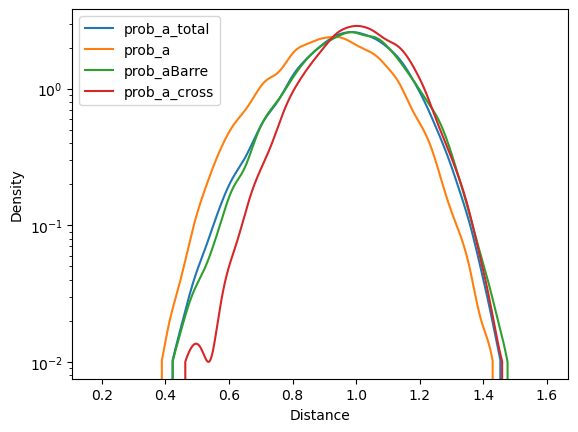

In [32]:
threshold = 1e-2
plt.plot(x,np.where(prob_a_total<threshold, 0, prob_a_total), label="prob_a_total")
plt.plot(x,np.where(prob_a<threshold, 0, prob_a), label="prob_a")
plt.plot(x,np.where(prob_aBarre<threshold, 0, prob_aBarre), label="prob_aBarre")
plt.plot(x,np.where(prob_a_cross<threshold, 0, prob_a_cross), label="prob_a_cross")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.yscale("log")
plt.legend()

## All attributes, by models

Attribute: Bald
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 115, 2357)
Using 115 samples

Attribute: Goatee
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 464, 2355)
Using 464 samples

Attribute: Gray_Hair
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 238, 2359)
Using 238 samples

Attribute: Mustache
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 409, 2357)
Using 409 samples

Attribute: Sideburns
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 496, 2356)
Using 496 samples

Attribute: Bald
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 115, 2357)
Using 115 samples

Attribute: Goatee
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre) = (500, 464, 2355)
Using 464 samples

Attribute: Gray_Hair
Not enough samples for attribute: MAX_SAMPLES, len(df_a), len(df_aBarre)

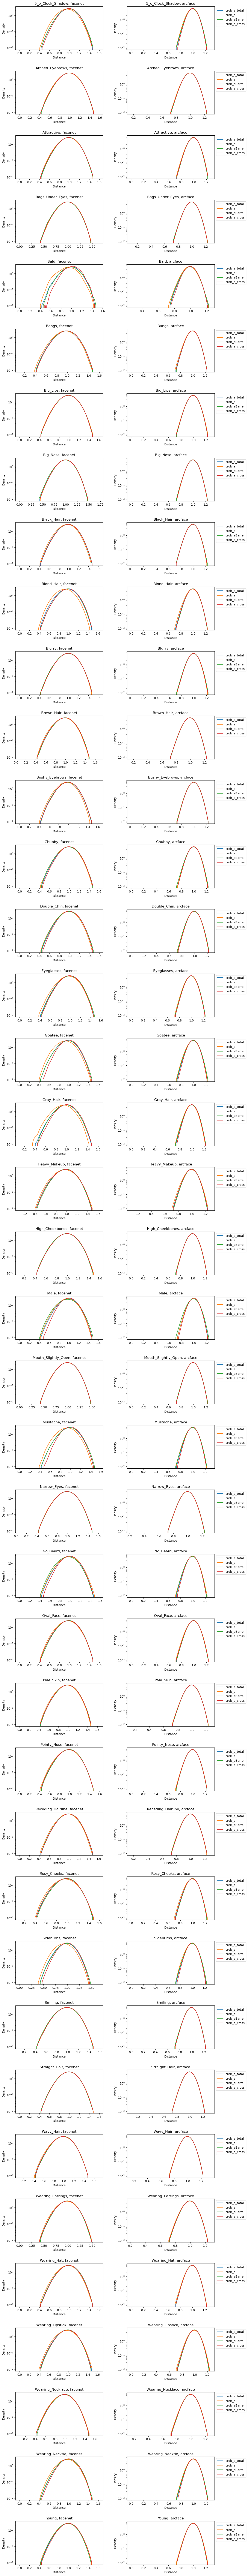

In [34]:
%%time
threshold = 1e-2
l_det_model, l_rec_model = ["retina"], ["facenet", "arcface"]

fig, ax = plt.subplots(nrows=len(l_cols_attributes), ncols=len(l_rec_model), figsize=(10,len(l_cols_attributes)*3))
fig.tight_layout(h_pad=5, w_pad=5)

for loop_model, (det_model, rec_model) in enumerate(itertools.product(l_det_model, l_rec_model)):
    a_embeddings = np.load(os.path.join(PATH_FROM_USER, f"embeddings_{det_model}_{rec_model}.npz"))["a"]
    for i, attribute in enumerate(l_cols_attributes):
        X_total, X_a, X_aBarre = get_pointClouds(a_embeddings, df_dataset, attribute)
        # get distances list
        a_total = get_distancesList(X_total, X_total)
        a_a = get_distancesList(X_a, X_a)
        a_aBarre = get_distancesList(X_aBarre, X_aBarre)
        a_cross = get_distancesList(X_a, X_aBarre)
        # kde estimate
        dist_range = (a_total.min(), a_total.max())
        x = np.linspace(*dist_range, 1000)
        prob_a_total = estimate_distanceProbability(a_total, x)
        prob_a = estimate_distanceProbability(a_a, x)
        prob_aBarre = estimate_distanceProbability(a_aBarre, x)
        prob_a_cross = estimate_distanceProbability(a_cross, x)
        # plotting
        row, col = i, loop_model
        ax[row, col].set_title(f"{attribute}, {rec_model}")
        ax[row, col].plot(x,np.where(prob_a_total<threshold, 0, prob_a_total), label="prob_a_total")
        ax[row, col].plot(x,np.where(prob_a<threshold, 0, prob_a), label="prob_a")
        ax[row, col].plot(x,np.where(prob_aBarre<threshold, 0, prob_aBarre), label="prob_aBarre")
        ax[row, col].plot(x,np.where(prob_a_cross<threshold, 0, prob_a_cross), label="prob_a_cross")
        ax[row, col].set_yscale("log")
        ax[row, loop_model].set_xlabel("Distance")
        ax[row, loop_model].set_ylabel("Density")
        if loop_model==len(l_rec_model)-1:
            ax[row, loop_model].legend(bbox_to_anchor=(1.0, 1), loc="upper left")

# Experiment 2

In [5]:
n_neighbors = 101  # number of nearest neighbors to retrieve (including same identity..)

# faiss parameters for SPEED UP/ NOT USING
nlist = int(np.sqrt(len(a_embeddings)))
d = a_embeddings.shape[1]
m = 8
nbits = 8  # number of bits per subquantizer, k* = 2**nbits

if REC_MODEL == "arcface":   
    index = faiss.IndexFlatIP(d)
    faiss.normalize_L2(a_embeddings)
    index.add(a_embeddings)
    similarities, ann = index.search(a_embeddings, n_neighbors)
    distances = 1-similarities
    
elif REC_MODEL == "facenet":
    
    # SPEED UP/ NOT USING
    # quantizer = faiss.IndexFlatL2(d)
    # index = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
    # index.train(a_embeddings)
    index = faiss.IndexFlatL2(d)
    index.add(a_embeddings)
    distances, ann = index.search(a_embeddings, n_neighbors)
else:
    raise ValueError(f"{REC_MODEL} is not a know case")

In [6]:
l = []

for idx, dist, neighbors in list(zip(np.arange(len(ann)), distances, ann))[:]:
    
    # remove same identity as query image in neighbors and dist
    identity_query = df_dataset.loc[idx, "identity"]  # get query image identity
    df_neighbors = df_dataset.loc[neighbors]
    mask_different_identity = (df_neighbors["identity"]!=identity_query).values
    df_neighbors = df_neighbors.loc[mask_different_identity]
    dist = dist[mask_different_identity]
    
    # compare attributes of query image and neighbors
    a_attributes_query = df_dataset.loc[[idx],l_cols_attributes].values
    a_attributes_neighbors = df_neighbors[l_cols_attributes].values
    kept_neighbors = n_neighbors - df_dataset.groupby("identity").size().max()
    M_cumsum = (a_attributes_neighbors == a_attributes_query).T[:, :kept_neighbors]  # TODO: not good, need to distinguish when attribute is True or False / use df_dataset[l_cols_attributes].values
    l.append(M_cumsum)
M_nn_binattributes = np.stack(l)
# reason like this: if neighbors were sampled through chance we would see this, but we see something else (balds are more likely to be sampled from a bald query)

In [16]:
# save / load

np.save(os.path.join(PATH_FROM_USER, *["attribute-embeddings-distance", f"experiment2_{DET_MODEL}_{REC_MODEL}.npy"]), M_nn_binattributes)
M_nn_binattributes = np.load(os.path.join(PATH_FROM_USER, *["attribute-embeddings-distance", f"experiment2_{DET_MODEL}_{REC_MODEL}.npy"]))

### Visualisation

In [32]:
def create_dataframeAttributes(df_dataset, M_nn_binattributes, l_cols_attributes):
    d_attributes = {}
    for i, attribute in enumerate(l_cols_attributes):

        # compute summaries
        idx_attribute = np.nonzero(l_cols_attributes==attribute)[0][0]
        a_idx_positive = df_dataset[df_dataset[attribute]==1].index
        a_idx_negative = df_dataset[df_dataset[attribute]==-1].index
        a_positive = M_nn_binattributes[a_idx_positive, idx_attribute].sum(axis=0)
        a_negative = M_nn_binattributes[a_idx_negative, idx_attribute].sum(axis=0)
        n_positive = len(a_idx_positive)
        n_negative = len(a_idx_negative)
        ratio_positive = n_positive/len(df_dataset)
        ratio_negative = n_negative/len(df_dataset)
        likelihood_positive = binom.logpmf(a_positive, n_positive, ratio_positive)
        likelihood_negative = binom.logpmf(a_negative, n_negative, ratio_negative)
        sum_likelihood_positive = likelihood_positive.sum()
        sum_likelihood_negative = likelihood_negative.sum()
        sum_likelihood = sum_likelihood_negative + sum_likelihood_positive

        # store everything
        d = {}
        d["idx_attribute"] = idx_attribute
        d["a_idx_positive"] = a_idx_positive
        d["a_idx_negative"] = a_idx_negative
        d["a_positive"] = a_positive
        d["a_negative"] = a_negative
        d["n_positive"] = n_positive
        d["n_negative"] = n_negative
        d["ratio_positive"] = ratio_positive
        d["ratio_negative"] = ratio_negative
        d["likelihood_positive"] = likelihood_positive
        d["likelihood_negative"] = likelihood_negative
        d["sum_likelihood_positive"] = sum_likelihood_positive
        d["likelihood_negative"] = likelihood_negative
        d["sum_likelihood"] = sum_likelihood
        d_attributes[attribute] = d
        
    return pd.DataFrame(d_attributes)

CPU times: user 6.02 s, sys: 725 ms, total: 6.75 s
Wall time: 5.97 s


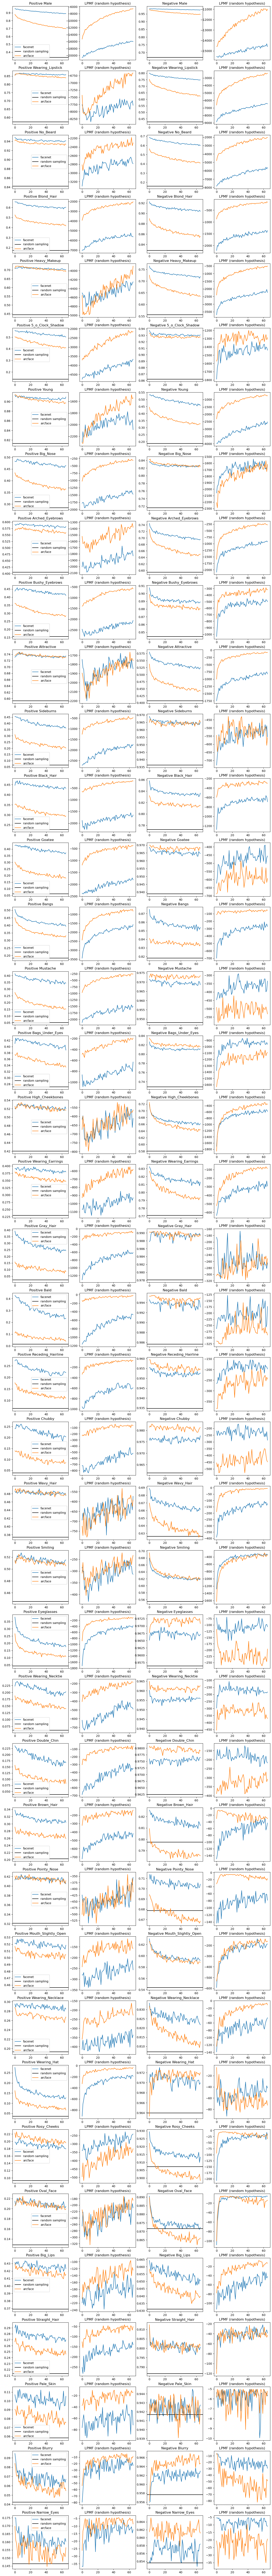

In [39]:
%%time

fig, ax = plt.subplots(len(l_cols_attributes),4,figsize=(16,4*40))


for loop_model, (det_model, rec_model) in enumerate(itertools.product(["retina"], ["facenet", "arcface"])):
    M_nn_binattributes = np.load(os.path.join(PATH_FROM_USER, *["attribute-embeddings-distance", f"experiment2_{det_model}_{rec_model}.npy"]))
    df_attributes = create_dataframeAttributes(df_dataset, M_nn_binattributes, l_cols_attributes)
    
    # set the order of columns according to the first model likelihoods summed
    if loop_model==0:
        l_cols_attributes_ordered = df_attributes.loc["sum_likelihood"].sort_values().index
    
    for i, attribute in enumerate(l_cols_attributes_ordered):
        
        idx_attribute = df_attributes.loc["idx_attribute", attribute]
        a_idx_positive = df_attributes.loc["a_idx_positive", attribute]
        a_idx_negative = df_attributes.loc["a_idx_negative", attribute]
        a_positive = df_attributes.loc["a_positive", attribute]
        a_negative = df_attributes.loc["a_negative", attribute]
        n_positive = df_attributes.loc["n_positive", attribute]
        n_negative = df_attributes.loc["n_negative", attribute]
        ratio_positive = df_attributes.loc["ratio_positive", attribute]
        ratio_negative = df_attributes.loc["ratio_negative", attribute]

        ax[i,0].plot(a_positive/n_positive, label=f"{rec_model}")
        if loop_model==0:
            ax[i,0].axhline(ratio_positive, color="black", label="random sampling")
        ax[i,0].set_title(f"Positive {attribute}")
        ax[i,0].legend()

        ax[i,1].plot(binom.logpmf(a_positive, n_positive, ratio_positive))
        ax[i,1].set_title(f"LPMF (random hypothesis)")

        ax[i,2].plot(a_negative/n_negative)
        if loop_model==0:
            ax[i,2].axhline(ratio_negative, color="black")
        ax[i,2].set_title(f"Negative {attribute}")

        ax[i,3].plot(binom.logpmf(a_negative, n_negative, ratio_negative))
        ax[i,3].set_title(f"LPMF (random hypothesis)")

# Experiment 3: on identities

Décliner la démarche sur les identités

# <>